##  Deep Fake Detection

In [9]:
import numpy as np
import cv2
import os

# Create directories
os.makedirs('dataset/real', exist_ok=True)
os.makedirs('dataset/fake', exist_ok=True)

# Generate synthetic real images (colored rectangles)
for i in range(100):
    img = np.zeros((128, 128, 3), dtype=np.uint8)
    color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    cv2.rectangle(img, (32, 32), (96, 96), color, -1)
    cv2.imwrite(f'dataset/real/real_{i}.png', img)

# Generate synthetic fake images (random noise)
for i in range(100):
    img = np.random.randint(0, 256, (128, 128, 3), dtype=np.uint8)
    cv2.imwrite(f'dataset/fake/fake_{i}.png', img)


In [10]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [11]:
def load_images(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

real_images, real_labels = load_images('dataset/real', 0)
fake_images, fake_labels = load_images('dataset/fake', 1)

In [12]:
# Combine and convert to numpy arrays
images = np.array(real_images + fake_images)
labels = np.array(real_labels + fake_labels)

In [13]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0


In [16]:
# Model Creation
from tensorflow.keras.layers import Input  # Ensure Input is imported

model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [18]:
# Train the Model
history = model.fit(train_generator, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.7000 - loss: 0.5413 - val_accuracy: 1.0000 - val_loss: 0.0591
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.9225 - loss: 0.1535 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 4.6509e-05
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 3.9256e-06
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 1.0000 - loss: 3.3913e-04 - val_accuracy: 1.0000 - val_loss: 9.1328e-07
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 1.0000 - loss: 1.1547e-04 - val_accuracy: 1.0000 - val_loss: 1.7203e-07
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 1.0000 - loss: 1.1960e-04 - val_accuracy: 1.0000 - val_loss: 3.0439e-08
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 1.0000 - loss: 3.7450e-05 - val_acc

In [19]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.0404e-14 
Test Accuracy: 100.00%


In [20]:
# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21  0]
 [ 0 19]]


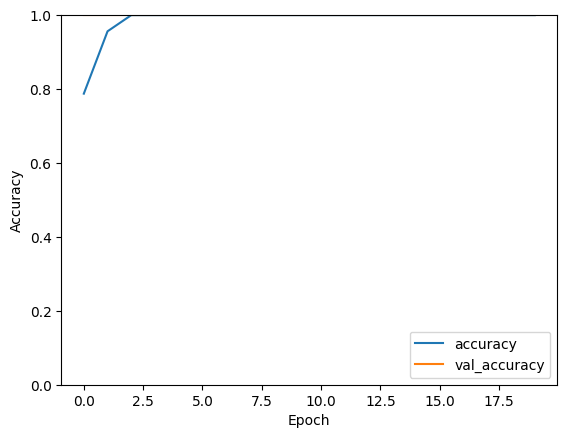

In [22]:
# Visualize Training History
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()